In [336]:
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
from common.utils.pickling import pickle_read, pickle_write
from common.utils.misc import load_samples, load_sample_loss_csv, load_sample_losses
import matplotlib.pyplot as plt
import networkx as nx
from prepare_submission_data import pkl_to_tar
import re
from collections import defaultdict
import random
from sklearn.neighbors import NearestNeighbors


#### load val stats

In [206]:
path = '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/validation_dataset/sample_stats_val.csv'
val = pd.read_csv(path)
val=val.rename(columns={val.columns[0]: 'path'})
val['path'] = val.path.str[2:]
val['dset'] = val.path.str.split('/',1).str[0]
print('unique datasets: ', val.dset.unique())
vgp = val.groupby('dset')
val.head()

unique datasets:  ['300' '200' '280' '260' '170' '100' '130' '50' '240' '75']


,path,LinkLoads_count,LinkLoads_mean,LinkLoads_std,LinkLoads_min,LinkLoads_10%,LinkLoads_25%,LinkLoads_50%,LinkLoads_70%,LinkLoads_80%,...,AvgDelay_std,AvgDelay_min,AvgDelay_10%,AvgDelay_25%,AvgDelay_50%,AvgDelay_70%,AvgDelay_80%,AvgDelay_90%,AvgDelay_max,dset
0,300/results_400-2000_11_11_s_0.pkl,776.0,1.091848,0.308750,0.379849,0.679497,0.801457,1.117181,1.305693,1.391213,...,0.008887,0.000394,0.004643,0.007227,0.011113,0.014846,0.017510,0.021912,0.179261,300
1,300/results_400-2000_12_12_s_0.pkl,776.0,0.719290,0.205462,0.321741,0.444692,0.527079,0.730278,0.864378,0.923076,...,0.003859,0.000382,0.003880,0.005762,0.008070,0.010224,0.011639,0.013692,0.040878,300
2,300/results_400-2000_14_14_s_0.pkl,776.0,0.740232,0.212065,0.341189,0.456906,0.544950,0.748168,0.882549,0.948578,...,0.003950,0.000388,0.003906,0.005826,0.008180,0.010382,0.011816,0.013940,0.044343,300
3,300/results_400-2000_25_25_s_0.pkl,750.0,0.348825,0.104240,0.148301,0.223425,0.255344,0.341565,0.420251,0.458045,...,0.002831,0.000339,0.003385,0.004546,0.006376,0.007963,0.008838,0.010379,0.021565,300
4,300/results_400-2000_26_26_s_0.pkl,750.0,1.048775,0.306220,0.480659,0.678468,0.766675,1.031695,1.248322,1.366252,...,0.007077,0.000416,0.004297,0.006284,0.009779,0.013254,0.015756,0.019890,0.077126,300


#### load training samples stats

In [393]:
stat_files = Path('/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/generated_datasets').glob('sample_stats*.csv')
df = pd.concat([pd.read_csv(p) for p in stat_files])

In [394]:
df=df.rename(columns={df.columns[0]: 'path'})
df['path'] = df.path.str[2:]
df['dset'] = df.path.str.split('/',1).str[0]
print('unique datasets: ', df.dset.unique())
gp = df.groupby('dset')
df.head()


unique datasets:  ['hard5_small6' '11' '14' '8' '5' '10' '12' '0' '2' '3' '13' '6' '7'
 'hard1' '9' '1' 'hard2' '15' '4' 'hard5_small' 'hard5' 'hard5_small4'
 'hard5_small3' 'hard3' 'hard4' 'hard5_small2' 'hard5_small5']


,path,LinkLoads_count,LinkLoads_mean,LinkLoads_std,LinkLoads_min,LinkLoads_10%,LinkLoads_25%,LinkLoads_50%,LinkLoads_70%,LinkLoads_80%,...,AvgDelay_std,AvgDelay_min,AvgDelay_10%,AvgDelay_25%,AvgDelay_50%,AvgDelay_70%,AvgDelay_80%,AvgDelay_90%,AvgDelay_max,dset
0,hard5_small6/2022-10-14__21-04-44__hard5_lbw_1...,25.0,0.545188,0.556938,0.124138,0.165758,0.190110,0.264015,0.581913,0.700200,...,0.650833,0.003302,0.032168,0.056027,0.120000,0.232109,1.523854,1.599709,2.001280,hard5_small6
1,hard5_small6/2022-10-14__21-03-58__hard5_lbw_f...,17.0,1.481120,0.404501,0.682901,1.005165,1.227665,1.517208,1.684233,1.849776,...,2.171946,0.029299,0.102865,0.194543,0.340031,1.323950,1.547162,5.469780,7.193350,hard5_small6
2,hard5_small6/2022-10-14__21-04-09__hard5_lbw_1...,16.0,0.580601,0.601186,0.127625,0.165514,0.207895,0.439933,0.537918,0.704974,...,0.657117,0.003284,0.016796,0.032749,0.058530,0.098441,0.304229,1.413027,2.183020,hard5_small6
3,hard5_small6/2022-10-14__21-03-58__hard5_lbw_f...,16.0,1.364998,0.388490,0.615443,0.832762,1.157767,1.443223,1.522744,1.554937,...,0.215321,0.045605,0.114871,0.171429,0.231124,0.280012,0.348251,0.762763,0.924496,hard5_small6
4,hard5_small6/2022-10-14__21-04-44__hard5_lbw_1...,20.0,0.603658,0.759572,0.156895,0.184450,0.228482,0.309781,0.549784,0.694530,...,0.689695,0.003407,0.016570,0.041576,0.128103,0.556312,0.818501,0.845557,3.609640,hard5_small6


In [139]:
df.columns

Index(['path', 'LinkLoads_count', 'LinkLoads_mean', 'LinkLoads_std',
       'LinkLoads_min', 'LinkLoads_10%', 'LinkLoads_25%', 'LinkLoads_50%',
       'LinkLoads_70%', 'LinkLoads_80%', 'LinkLoads_90%', 'LinkLoads_max',
       'PktsDrop_count', 'PktsDrop_mean', 'PktsDrop_std', 'PktsDrop_min',
       'PktsDrop_10%', 'PktsDrop_25%', 'PktsDrop_50%', 'PktsDrop_70%',
       'PktsDrop_80%', 'PktsDrop_90%', 'PktsDrop_max', 'AvgDelay_count',
       'AvgDelay_mean', 'AvgDelay_std', 'AvgDelay_min', 'AvgDelay_10%',
       'AvgDelay_25%', 'AvgDelay_50%', 'AvgDelay_70%', 'AvgDelay_80%',
       'AvgDelay_90%', 'AvgDelay_max', 'dset'],
      dtype='object')

In [386]:
ss = pd.concat((gp.describe().sort_index(), vgp.describe().sort_index()))

In [217]:
# ss['LinkLoads_80%']
# ss['PktsDrop_80%']
ss['AvgDelay_80%']
#ss['PktsDrop_std']

,count,mean,std,min,25%,50%,75%,max
dset,,,,,,,,
0,9714.0,1.275041,3.893841,0.008573,0.035625,0.068899,1.156866,244.010000
1,19370.0,1.378271,3.563134,0.012711,0.045166,0.233508,1.663560,279.744000
10,10456.0,0.893708,2.079986,0.066017,0.223097,0.315630,0.596844,71.139240
11,10446.0,1.825873,3.320894,0.104765,0.416225,0.792056,2.100574,127.484400
12,10331.0,9.908965,27.047307,0.210087,4.431619,6.874036,10.777760,1864.270000
13,10348.0,12.484597,119.370823,0.333281,4.446900,6.902867,10.738825,9088.632000
14,10343.0,5.599239,17.501715,0.089436,1.820849,3.534250,6.485435,1317.240000
15,10350.0,3.248137,8.669412,0.097862,0.340110,1.246013,4.144127,734.806400
2,11769.0,0.883263,2.361939,0.009954,0.027531,0.050843,0.625919,50.812660


In [196]:
# gp['LinkLoads_80%'].describe()
gp['PktsDrop_80%'].describe()
# gp['AvgDelay_50%'].describe()


count      mean       std  min       25%  \
lbw        avgbw   bsz                                                 
40k-100k_1 large_1 small_1   20.0  0.052228  0.146993  0.0  0.000008   
                   small_2   20.0  0.194144  0.253864  0.0  0.000017   
           large_2 small_1   19.0  0.126964  0.234741  0.0  0.000004   
                   small_2   20.0  0.059049  0.102663  0.0  0.000000   
40k-100k_2 large_1 small_1   20.0  0.123108  0.244214  0.0  0.000000   
                   small_2   20.0  0.144866  0.313146  0.0  0.000000   
           large_2 small_1   19.0  0.164721  0.286261  0.0  0.000014   
                   small_2   20.0  0.187099  0.216714  0.0  0.000008   
40k-100k_3 large_1 small_1   19.0  0.153758  0.249657  0.0  0.000000   
                   small_2   19.0  0.158596  0.266060  0.0  0.000000   
           large_2 small_1   20.0  0.132560  0.223914  0.0  0.000000   
                   small_2   20.0  0.104246  0.218367  0.0  0.000000   

                                 50%       75%       max  
lbw        avgbw   bsz                                    
40k-100k_1 large_1 small_1  0.000298  0.009025  0.636110  
                   small_2  0.048662  0.369845  0.890805  
           large_2 small_1  0.006050  0.147245  0.745903  
                   small_2  0.004839  0.044093  0.306449  
40k-100k_2 large_1 small_1  0.006374  0.207785  1.061554  
                   small_2  0.006778  0.177562  1.362610  
           large_2 small_1  0.026937  0.213884  1.110232  
                   small_2  0.072522  0.316120  0.697785  
40k-100k_3 large_1 small_1  0.000000  0.273318  0.836926  
                   small_2  0.001271  0.168713  0.883915  
           large_2 small_1  0.001754  0.218437  0.683424  
                   small_2  0.000202  0.041478  0.626720

### drill down into hard5

In [326]:
d=gp.get_group('hard5_small').copy()
d['p'] = d.path.str.extract(r'p_(0.\d)')[0].astype(float)
d['lbw'] = d.path.str.extract(r'lbw_(.*?)_bsz')[0]
d['bsz'] = d.path.str.extract(r'bsz_(.*?)_avgbw')[0]
d['avgbw'] = d.path.str.extract(r'avgbw_(.*?)_netsz')[0]
d['netsz'] = d.path.str.extract(r'netsz_(\d+)_')[0].astype(int)
for c in ['netsz', 'p', 'lbw', 'bsz', 'avgbw']:
    print(f'{c}: {d[c].unique()}')

netsz: [10  9]
p: [0.3]
lbw: ['40k-100k_3' '40k-100k_2' '40k-100k_1']
bsz: ['small_2' 'small_1']
avgbw: ['large_2' 'large_1']


In [327]:
g = d.groupby(['lbw', 'avgbw', 'bsz'])
vgp = val.groupby('dset')
for c in ['LinkLoads_80%']: #, 'PktsDrop_80%', 'AvgDelay_50%', 'LinkLoads_80%']:
    print(c)
    print(g[c].describe()[['mean', 'std', '50%', 'min', 'max']], '\n')
    print(gp[c].describe()[['mean','std', '50%', 'min', 'max']].loc[['hard4']], '\n')
    print('val')
    print(vgp[c].describe()[['mean','std','50%', 'min', 'max']], '\n')
    

LinkLoads_80%
                                mean       std       50%       min       max
lbw        avgbw   bsz                                                      
40k-100k_1 large_1 small_1  1.040477  0.210237  1.048540  0.759142  1.496492
                   small_2  1.082471  0.318264  1.077353  0.571886  2.107891
           large_2 small_1  1.177945  0.268778  1.177284  0.737227  1.628049
                   small_2  1.118800  0.250240  1.076528  0.738519  1.480491
40k-100k_2 large_1 small_1  1.064529  0.554491  1.005703  0.396654  2.850305
                   small_2  0.966708  0.377381  0.853329  0.562241  2.299269
           large_2 small_1  1.021233  0.296985  1.051258  0.523434  1.635888
                   small_2  1.106586  0.454152  1.140755  0.432225  2.504900
40k-100k_3 large_1 small_1  0.846443  0.474025  0.695485  0.316823  2.048946
                   small_2  0.750198  0.442120  0.567408  0.281835  2.123646
           large_2 small_1  0.838460  0.313615  0.736120  0.47

In [261]:
linkcols = ['LinkLoads_min', 'LinkLoads_10%', 'LinkLoads_25%', 'LinkLoads_50%',
            'LinkLoads_70%', 'LinkLoads_80%', 'LinkLoads_90%',]# 'LinkLoads_max']
dropcols = ['PktsDrop_min', 'PktsDrop_10%', 'PktsDrop_25%', 'PktsDrop_50%', 'PktsDrop_70%',
            'PktsDrop_80%', 'PktsDrop_90%', ] #'PktsDrop_max']
delaycols = ['AvgDelay_min', 'AvgDelay_10%',
             'AvgDelay_25%', 'AvgDelay_50%', 'AvgDelay_70%', 'AvgDelay_80%',
             'AvgDelay_90%', ] #'AvgDelay_max']


In [ ]:
gp = d.groupby(['lbw', 'avgbw', 'bsz'])
for x, y in gp:
    name = '_'.join(x)
    print(name)

In [220]:
dd = d.groupby(['lbw', 'avgbw', 'bsz']).get_group(('100k_1', 'uniform2k', 'small_1'))
dd

,path,LinkLoads_count,LinkLoads_mean,LinkLoads_std,LinkLoads_min,LinkLoads_10%,LinkLoads_25%,LinkLoads_50%,LinkLoads_70%,LinkLoads_80%,...,AvgDelay_70%,AvgDelay_80%,AvgDelay_90%,AvgDelay_max,dset,p,lbw,bsz,avgbw,netsz
49,hard5_small2/2022-10-13__15-29-14__hard3_lbw_1...,14.0,0.254739,0.181065,0.063897,0.117318,0.172732,0.221236,0.240980,0.252799,...,0.079173,0.086400,0.101178,0.119682,hard5_small2,0.3,100k_1,small_1,uniform2k,9
50,hard5_small2/2022-10-13__15-29-14__hard3_lbw_1...,10.0,0.350175,0.502870,0.058934,0.090755,0.141837,0.179328,0.256617,0.307644,...,0.067380,0.218357,0.594100,0.696272,hard5_small2,0.3,100k_1,small_1,uniform2k,9
51,hard5_small2/2022-10-13__15-29-14__hard3_lbw_1...,15.0,0.499892,0.634974,0.114733,0.136474,0.194857,0.240041,0.477330,0.688090,...,2.089110,6.229422,6.290962,6.361110,hard5_small2,0.3,100k_1,small_1,uniform2k,9
52,hard5_small2/2022-10-13__15-29-14__hard3_lbw_1...,9.0,0.389715,0.444656,0.077622,0.117218,0.146115,0.179632,0.358352,0.463254,...,0.075921,0.184121,0.223938,0.502941,hard5_small2,0.3,100k_1,small_1,uniform2k,9
53,hard5_small2/2022-10-13__15-29-14__hard3_lbw_1...,10.0,0.262386,0.278549,0.044699,0.058546,0.074595,0.171248,0.247898,0.421452,...,0.068802,0.077726,0.085186,0.110396,hard5_small2,0.3,100k_1,small_1,uniform2k,9
54,hard5_small2/2022-10-13__15-29-14__hard3_lbw_1...,10.0,0.244663,0.172134,0.035548,0.082512,0.135190,0.218796,0.269524,0.312668,...,0.058464,0.068474,0.081680,0.130916,hard5_small2,0.3,100k_1,small_1,uniform2k,9
55,hard5_small2/2022-10-13__15-29-14__hard3_lbw_1...,14.0,0.194332,0.133655,0.053835,0.072111,0.115649,0.177352,0.209231,0.224687,...,0.064439,0.073172,0.090140,0.102455,hard5_small2,0.3,100k_1,small_1,uniform2k,9
56,hard5_small2/2022-10-13__15-29-14__hard3_lbw_1...,12.0,0.393214,0.524990,0.073006,0.112919,0.183670,0.248121,0.306810,0.348562,...,0.092165,0.209205,0.634831,0.699692,hard5_small2,0.3,100k_1,small_1,uniform2k,9
57,hard5_small2/2022-10-13__15-29-14__hard3_lbw_1...,9.0,0.260520,0.211263,0.080483,0.117175,0.142003,0.245388,0.255820,0.275754,...,0.057998,0.061763,0.070930,0.090962,hard5_small2,0.3,100k_1,small_1,uniform2k,9
58,hard5_small2/2022-10-13__15-29-14__hard3_lbw_1...,11.0,0.226353,0.159723,0.090663,0.096204,0.136929,0.150698,0.210028,0.308709,...,0.057947,0.066394,0.076193,0.144455,hard5_small2,0.3,100k_1,small_1,uniform2k,9


### compare stats to val

In [388]:
# load oracle loss
p_oracle_val_loss = '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/trained_oracle_models/6.44/losses_27-6.44/val_sample_loss_27-6.44.csv'
ora_loss = load_sample_loss_csv(p_oracle_val_loss).sort_values('loss', ascending=False)
ora_loss['spath'] = ora_loss.path.str.replace('/mnt/ext/shared/Projects/GNNetworkingChallenge/validation_dataset_pkl/','')
#ora_loss.iloc[0].spath

# load val stats
path = '/mnt/ext-10g/shared/Projects/GNNetworkingChallenge/validation_dataset/sample_stats_val.csv'
val = pd.read_csv(path)
val=val.rename(columns={val.columns[0]: 'spath'})
val['path'] = '/mnt/ext/shared/Projects/GNNetworkingChallenge/validation_dataset_pkl/' + val.spath.str[2:]
val = pd.merge(ora_loss, val.drop('spath', axis=1), on='path')
print('unique datasets: ', val.dset.unique())
val.head()

unique datasets:  ['170' '240' '200' '130' '280' '100' '300' '75' '50' '260']


,path,loss,flows,net_size,wloss,dset,spath,LinkLoads_count,LinkLoads_mean,LinkLoads_std,...,AvgDelay_mean,AvgDelay_std,AvgDelay_min,AvgDelay_10%,AvgDelay_25%,AvgDelay_50%,AvgDelay_70%,AvgDelay_80%,AvgDelay_90%,AvgDelay_max
0,/mnt/ext/shared/Projects/GNNetworkingChallenge...,23.864992,28730,170,0.143498,170,170/results_400-2000_5_5_s_0.pkl,368.0,1.662027,0.382000,...,0.079334,0.107321,0.001019,0.012901,0.022980,0.041631,0.068605,0.103911,0.179093,0.98187
1,/mnt/ext/shared/Projects/GNNetworkingChallenge...,22.858261,28730,170,0.137445,170,170/results_400-2000_8_8_s_0.pkl,368.0,1.594005,0.375664,...,0.075805,0.105450,0.000934,0.012468,0.021464,0.037375,0.061471,0.094833,0.186805,1.21533
2,/mnt/ext/shared/Projects/GNNetworkingChallenge...,21.996872,57360,240,0.264071,240,240/results_400-2000_29_29_s_0.pkl,486.0,1.545393,0.449241,...,0.057326,0.091150,0.000536,0.006213,0.009713,0.020331,0.049827,0.080603,0.156023,1.13566
3,/mnt/ext/shared/Projects/GNNetworkingChallenge...,21.312956,39800,200,0.177532,200,200/results_400-2000_7_7_s_0.pkl,426.0,1.542006,0.436834,...,0.071533,0.100754,0.000977,0.007338,0.014021,0.030023,0.065107,0.102910,0.202910,0.92949
4,/mnt/ext/shared/Projects/GNNetworkingChallenge...,20.793732,39800,200,0.173207,200,200/results_400-2000_29_29_s_0.pkl,416.0,1.615281,0.447635,...,0.080519,0.111001,0.000530,0.007559,0.014160,0.033854,0.077272,0.130815,0.218548,1.18231


In [408]:
dset = {}
# for n in ['hard4', 'hard5_small', 'hard5_small2', 'hard5_small3']:
for n in ['hard5_small6', 'hard5_small4']: #['hard5_small5', 'hard5_small4']: #'hard5_small3']: #, 'hard5_small3']:
    d = gp.get_group(n).copy()
    d['p'] = d.path.str.extract(r'p_(0.\d)')[0].astype(float)
    d['lbw'] = d.path.str.extract(r'lbw_(.*?)_bsz')[0]
    d['bsz'] = d.path.str.extract(r'bsz_(.*?)_avgbw')[0]
    d['avgbw'] = d.path.str.extract(r'avgbw_(.*?)_')[0]
    d['netsz'] = d.path.str.extract(r'netsz_(\d+)_')[0].astype(int)
    dset[n] = d
    print(f'{n}: p: ', d['p'].unique(), 'netsz: ', d['netsz'].unique())
    print(f'{n}: lbw: ', d['lbw'].unique())
    print(f'{n}: bsz: ', d['bsz'].unique())
    print(f'{n}: avgbw: ', d['avgbw'].unique())


hard5_small6: p:  [0.4] netsz:  [10]
hard5_small6: lbw:  ['100k_4' 'from_traffic-above' '100k_3']
hard5_small6: bsz:  ['small_2' 'small_1']
hard5_small6: avgbw:  ['uniform4.5k' 'uniform2k-6k']
hard5_small4: p:  [0.3] netsz:  [10]
hard5_small4: lbw:  ['from_traffic-above']
hard5_small4: bsz:  ['small_1']
hard5_small4: avgbw:  ['large']


<IPython.core.display.Javascript object>


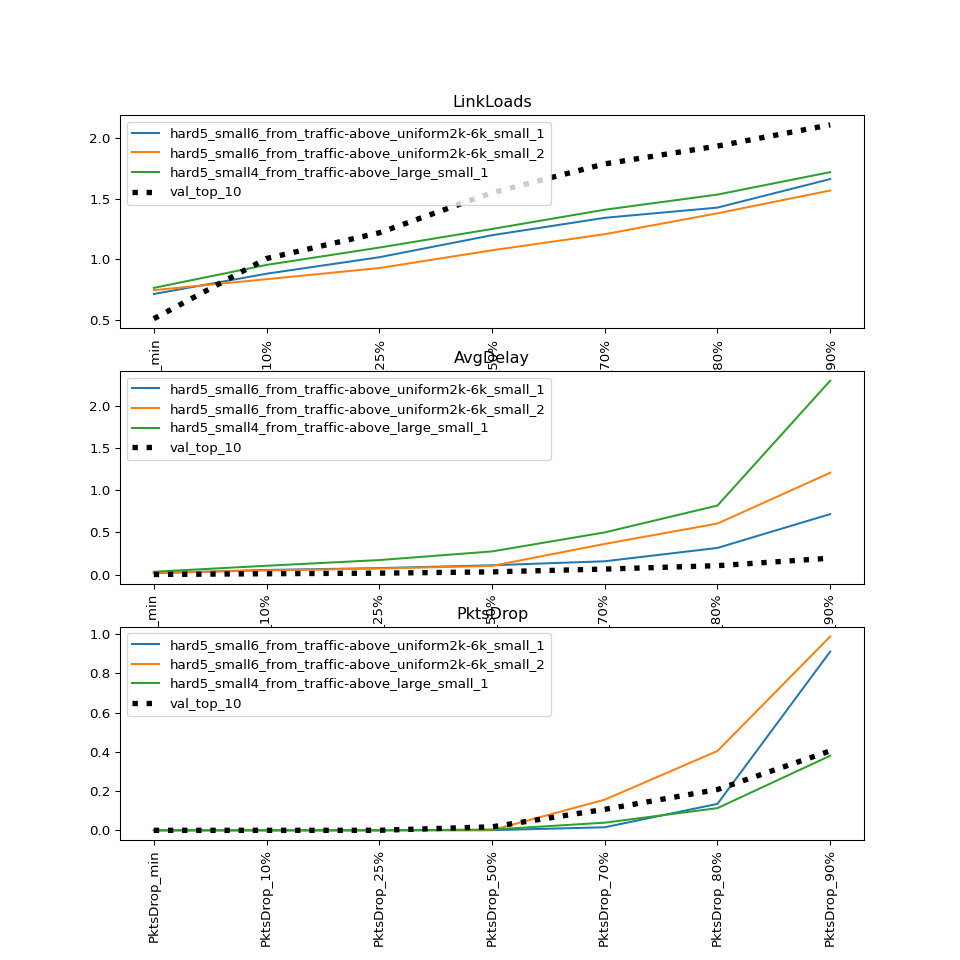

('100k_3', 'uniform2k-6k', 'small_1')
('100k_3', 'uniform2k-6k', 'small_2')
('100k_3', 'uniform4.5k', 'small_1')
('100k_3', 'uniform4.5k', 'small_2')
('100k_4', 'uniform2k-6k', 'small_1')
('100k_4', 'uniform2k-6k', 'small_2')
('100k_4', 'uniform4.5k', 'small_1')
('100k_4', 'uniform4.5k', 'small_2')
('from_traffic-above', 'uniform2k-6k', 'small_1')
('from_traffic-above', 'uniform2k-6k', 'small_2')
('from_traffic-above', 'uniform4.5k', 'small_1')
('from_traffic-above', 'uniform4.5k', 'small_2')
('from_traffic-above', 'large', 'small_1')
('100k_3', 'uniform2k-6k', 'small_1')
('100k_3', 'uniform2k-6k', 'small_2')
('100k_3', 'uniform4.5k', 'small_1')
('100k_3', 'uniform4.5k', 'small_2')
('100k_4', 'uniform2k-6k', 'small_1')
('100k_4', 'uniform2k-6k', 'small_2')
('100k_4', 'uniform4.5k', 'small_1')
('100k_4', 'uniform4.5k', 'small_2')
('from_traffic-above', 'uniform2k-6k', 'small_1')
('from_traffic-above', 'uniform2k-6k', 'small_2')
('from_traffic-above', 'uniform4.5k', 'small_1')
('from_tra

In [423]:
%matplotlib notebook
#%matplotlib inline

#f = plt.figure(figsize = (10,10))
f, axx = plt.subplots(3,1,figsize = (10,10))
cols = linkcols

matches = [#('100k_4', None, None),
           ('hard5_small6', 'from_traffic-above', 'uniform2k-6k', '*'),
#            ('hard5_small6', '100k_3', '*', '*'),
           ('hard5_small4', '*', '*', '*'),
]
def comp(n, t1, t2):
    for a, b in zip([n,*t1], t2):
        if a != b and a not in ['*', None] and b not in ['*', None]:
            return False
    return True

for i, cols in enumerate([linkcols, delaycols, dropcols]):
    plt.sca(axx[i])
    for n, d in dset.items():
        for kk, dd in d.groupby(['lbw', 'avgbw', 'bsz']):
            print(kk)
            if all (comp(n, kk, mm)==False for mm in matches):
                continue
#             if kk[0] == 'from_traffic-above' or kk[0] == 'from_traffic-nearest': #'100k_3': # and kk[2] == 'small_1': #uniform4.5k': # kk[2] =='small_1':
#             if kk[0] =='100k_3':
            name = n + '_' + '_'.join(kk)
            plt.plot(dd[cols].mean().values.T, label=name)

    # val
    ntop=10
    vv = val.iloc[:ntop][cols].mean(axis=0).values.T
    plt.plot(vv, label=f'val_top_{ntop}', linestyle=':' , linewidth=4, color='black')
    
#     p = '170/results_400-2000_5_5_s_0.pkl'
#     vv = val[val.path == p].iloc[0]
#     plt.plot(vv[cols].values.T, label=p, linestyle=':' , linewidth=4, color='black')
    plt.title(cols[0][:-4])

    plt.legend()
    plt.xticks(ticks=list(range(len(cols))), labels=cols, rotation='vertical');

In [238]:
vv[delaycols]

AvgDelay_min    0.001019
AvgDelay_10%    0.012901
AvgDelay_25%     0.02298
AvgDelay_50%    0.041631
AvgDelay_70%    0.068605
AvgDelay_80%    0.103911
AvgDelay_90%    0.179093
Name: 56, dtype: object

In [130]:
hd = df[(df.dset=='hard1')].copy()
hd['lbw'] = hd.path.str.extract(r'lbw_(.*?)_bsz')[0]
hd['bsz'] = hd.path.str.extract(r'bsz_(.*?)_netsz')[0]
g = hd.groupby(['lbw', 'bsz'])
for c in ['LinkLoads_80%', 'PktsDrop_80%', 'AvgDelay_50%']:
    print(c)
    print(g[c].describe()[['mean', 'std', '50%', 'min', 'max']], '\n')


LinkLoads_80%
                       mean       std       50%       min       max
lbw       bsz                                                      
10k-25k_1 small_1  2.049701  0.658729  1.983360  0.665583  4.856862
          uniform  2.016103  0.648274  1.918699  0.713658  5.702778 

PktsDrop_80%
                       mean       std       50%  min       max
lbw       bsz                                                 
10k-25k_1 small_1  0.398411  0.254757  0.380784  0.0  1.401466
          uniform  0.395948  0.264938  0.373533  0.0  1.723690 

AvgDelay_50%
                       mean       std       50%       min       max
lbw       bsz                                                      
10k-25k_1 small_1  2.105843  2.115133  1.373730  0.106784  14.94025
          uniform  2.110915  2.142664  1.260214  0.155863  16.77875 



,LinkLoads_count,LinkLoads_mean,LinkLoads_std,LinkLoads_min,LinkLoads_10%,LinkLoads_25%,LinkLoads_50%,LinkLoads_70%,LinkLoads_80%,LinkLoads_90%,...,AvgDelay_mean,AvgDelay_std,AvgDelay_min,AvgDelay_10%,AvgDelay_25%,AvgDelay_50%,AvgDelay_70%,AvgDelay_80%,AvgDelay_90%,AvgDelay_max
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,...,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,399.138462,0.916223,0.258469,0.348661,0.587499,0.709431,0.901794,1.062559,1.152826,1.268368,...,0.036865,0.062277,0.001382,0.009008,0.013605,0.020797,0.031420,0.043405,0.076011,1.053745
std,210.226004,0.369108,0.105485,0.152375,0.236802,0.292187,0.369041,0.426781,0.463169,0.509050,...,0.042294,0.112911,0.001285,0.005223,0.008316,0.014030,0.026621,0.046042,0.109360,2.603487
min,114.000000,0.301477,0.082622,0.050597,0.193400,0.224868,0.277077,0.342011,0.395814,0.425343,...,0.005467,0.002400,0.000333,0.002701,0.003715,0.005086,0.006350,0.007266,0.008677,0.021565
25%,216.000000,0.673260,0.189617,0.242948,0.440302,0.508661,0.652478,0.786873,0.854424,0.956008,...,0.010646,0.004895,0.000414,0.004643,0.007012,0.009833,0.012750,0.014269,0.016593,0.047708
50%,414.000000,0.937392,0.263468,0.338266,0.575615,0.700035,0.884733,1.082298,1.179675,1.334141,...,0.018973,0.010700,0.000884,0.007630,0.011738,0.016536,0.021470,0.025241,0.030226,0.179227
75%,486.000000,1.151440,0.319666,0.451394,0.721389,0.950545,1.165912,1.316832,1.396189,1.505479,...,0.038751,0.067627,0.001268,0.011871,0.019434,0.029426,0.041365,0.049497,0.076076,1.128547
max,838.000000,1.662027,0.461705,0.719230,1.103777,1.431572,1.709993,1.907412,2.048365,2.196424,...,0.237986,0.865343,0.004690,0.025240,0.040051,0.069645,0.129280,0.259690,0.622140,26.218300
